In [10]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
import ta
import ccxt
import datetime
import dateutil
import pandas_datareader.data as pdr
from stocktrends import Renko
import matplotlib.pyplot as plt
import matplotlib

In [11]:
# pairList = pairJson['hitbtc2018']
pair = 'ETH/USDT'
timeframe = '1h'
startDate = '2017-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='./database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)
df.rename(columns={'timestamp', 'date'}, inplace=True)
print (df)

Successfully load 40753 candles for ETHUSDT
                        open     high      low    close      volume
timestamp                                                          
2017-08-17 04:00:00   301.13   302.57   298.00   301.61   125.66877
2017-08-17 05:00:00   301.61   303.28   300.00   303.10   377.67246
2017-08-17 06:00:00   302.40   304.44   301.90   302.68   303.86672
2017-08-17 07:00:00   302.68   307.96   302.60   307.96   754.74510
2017-08-17 08:00:00   307.95   309.97   307.00   308.62   150.75029
...                      ...      ...      ...      ...         ...
2022-04-16 06:00:00  3041.77  3041.77  3035.29  3037.74  2878.67450
2022-04-16 07:00:00  3037.74  3040.80  3033.27  3034.64  4736.45640
2022-04-16 08:00:00  3034.64  3041.84  3027.71  3034.96  8344.50530
2022-04-16 09:00:00  3034.96  3038.83  3031.51  3033.73  5104.73790
2022-04-16 10:00:00  3033.74  3042.99  3032.69  3041.20  5018.88060

[40753 rows x 5 columns]


In [8]:
# Function to convert ohlc data into renko bricks. Pass dataframe name and brick size
def df_to_renko(data, n):
    data.reset_index(inplace=True)
    data.columns = [i.lower() for i in data.columns]
    print(data.isnull().values.any())
    df = Renko(data)
    df.brick_size = n
    renko_df = df.get_ohlc_data()
    return renko_df

In [9]:
r_bars = df_to_renko(df, 50)
print('# of rows in DF:',len(r_bars))

False


KeyError: "['date'] not in index"

In [12]:
new_df = r_bars[['open','close']]

Pair Symbol : ETH/USDT | Timeframe : 1h
Period : [2022-01-01 00:00:00] -> [2022-04-16 10:00:00]
Starting balance : 999.3000000000001 $

----- General Informations -----
Final balance : 949.87 $
Performance vs US Dollar : -4.95 %
Buy and Hold Performence : -18.31 %
Performance vs Buy and Hold : 16.37 %
Best trade : +14.21 %, the 2022-02-05 03:00:00
Worst trade : -7.22 %, the 2022-01-21 23:00:00
Worst drawDown : - 27.74 %
Total fees :  84.43 $

----- Trades Informations -----
Total trades on period : 67
Number of positive trades : 28
Number of negative trades :  39
Trades win rate ratio : 41.79 %
Average trades performance : 0.07 %
Average positive trades : 3.31 %
Average negative trades : -2.26 %

----- Time Informations -----
Average time duration for a trade : 15.39 periods
Maximum time duration for a trade : 33 periods
Minimum time duration for a trade : 2 periods
Average time duration between two trades : 21.65 periods
Maximum time duration between two trades : 74 periods
Minimum ti

----- 2022 Performances: -4.95% -----


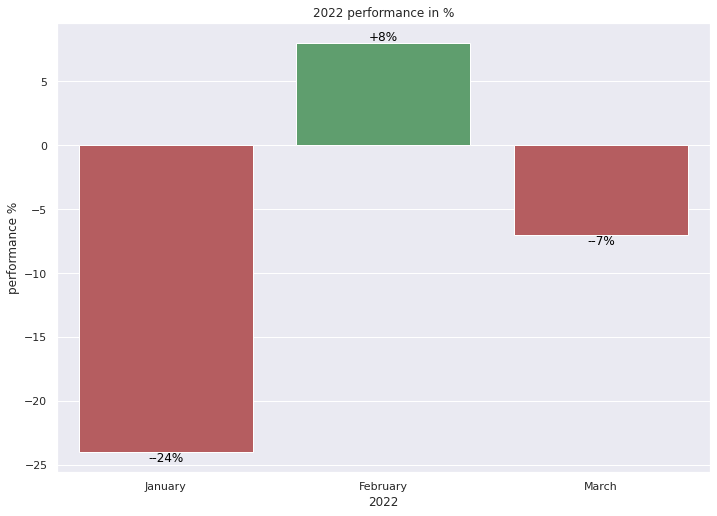

In [13]:
# create the figure
fig = plt.figure(1)
fig.clf()
axes = fig.gca()

# Add 10 extra spaces to the right
num_bars = 100
df = new_df.tail(num_bars)

renkos = zip(df['open'],df['close'])
# plot the bars, green for 'up', red for 'down'
index = 1

for open_price, close_price in renkos:
    if (open_price < close_price):
        renko = matplotlib.patches.Rectangle((index,open_price), 1, close_price-open_price, edgecolor='black', facecolor='green', alpha=0.5)
        axes.add_patch(renko)
    else:
        renko = matplotlib.patches.Rectangle((index,open_price), 1, close_price-open_price, edgecolor='black', facecolor='red', alpha=0.5)
        axes.add_patch(renko)
    index = index + 1
    
#adjust the axes
plt.xlim([0, num_bars+5])
plt.ylim([min(min(df['open']),min(df['close'])), max(max(df['open']),max(df['close']))])
plt.grid(True)
plt.show()